# Task 1: Word Embeddings (10 points)

This notebook will guide you through all steps necessary to train a word2vec model (Detailed description in the PDF).

## Imports

This code block is reserved for your imports. 

You are free to use the following packages: 

(List of packages)

In [2]:
############ loading all the necessary packages ############
import torch
from torch import nn
import pandas as pd
import re
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from tqdm import tqdm
from torchsummary import summary
import matplotlib.pylab as plt
import pickle

# 1.1 Get the data (0.5 points)

The Hindi portion HASOC corpus from [github.io](https://hasocfire.github.io/hasoc/2019/dataset.html) is already available in the repo, at data/hindi_hatespeech.tsv . Load it into a data structure of your choice. Then, split off a small part of the corpus as a development set (~100 data points).

If you are using Colab the first two lines will let you upload folders or files from your local file system.

In [6]:
#TODO: implement!

#from google.colab import files
#uploaded = files.upload()

############ reading the the tsv file into data ############ 
data = pd.read_csv('hindi_hatespeech.tsv', sep='\t')

data.head() # looking at the first 5 rows of the data


,text_id,text,task_1,task_2,task_3
0,hasoc_hi_5556,"बांग्लादेश की शानदार वापसी, भारत को 314 रन पर ...",NOT,NONE,NONE
1,hasoc_hi_5648,सब रंडी नाच देखने मे व्यस्त जैसे ही कोई #शांती...,HOF,PRFN,UNT
2,hasoc_hi_164,तुम जैसे हरामियों के लिए बस जूतों की कमी है शु...,HOF,PRFN,TIN
3,hasoc_hi_3530,"बीजेपी MLA आकाश विजयवर्गीय जेल से रिहा, जमानत ...",NOT,NONE,NONE
4,hasoc_hi_5206,चमकी बुखार: विधानसभा परिसर में आरजेडी का प्रदर...,NOT,NONE,NONE


In [7]:
data = data.sample(1000) # sampling 1000 data points from the loaded data
data.shape # checking the shape of the data

(1000, 5)

## 1.2 Data preparation (0.5 + 0.5 points)

* Prepare the data by removing everything that does not contain information. 
User names (starting with '@') and punctuation symbols clearly do not convey information, but we also want to get rid of so-called [stopwords](https://en.wikipedia.org/wiki/Stop_word), i. e. words that have little to no semantic content (and, but, yes, the...). Hindi stopwords can be found [here](https://github.com/stopwords-iso/stopwords-hi/blob/master/stopwords-hi.txt) Then, standardize the spelling by lowercasing all words.
Do this for the development section of the corpus for now.

* What about hashtags (starting with '#') and emojis? Should they be removed too? Justify your answer in the report, and explain how you accounted for this in your implementation.

In [8]:
USERNAME_PATTERN = r'@([A-Za-z0-9_]+)' # specifying the pattern for identifying usernames
PUNCTUATION_PATTERN = '\'’|!@$%^&*()_+<>?:.,;-' # specifying the pattern for identifying punctuations

In [9]:
stopwords_hindi_file = open('stopwords-hi.txt', 'r') # loading the file with stopwords for hindi dataset
stopwords_hindi = [line.replace('\n','') for line in stopwords_hindi_file.readlines()]

In [10]:
#TODO: implement!
def remove_punctuations(text):
  '''
  this method removes the punctuations in a given text 
  using the PUNCTUATION_PATTERN specified.

  Arguments: 
  text -- string containing the punctuations.

  Return:
  text -- string with no punctuations.
  '''
  return "".join([c for c in text if c not in PUNCTUATION_PATTERN])



def remove_stopwords(text):
  '''
  this method removes the stop words in a given text 
  using the stopwords_hindi specified.

  Arguments: 
  text -- string containing the stop words.

  Return:
  text -- string with no stop words.
  '''
  return " ".join([word for word in text.split() if word not in stopwords_hindi])



def remove_usernames(text):  
  '''
  this method removes any usernames in a given text 
  using the USERNAME_PATTERN specified.

  Arguments: 
  text -- string containing the usernames.

  Return:
  text -- string with no usernames.
  '''
  return re.sub(USERNAME_PATTERN, '', text)
  

In [11]:
## normalizing text to lower case
data['clean_text'] = data.text.apply(lambda text: text.lower())

## removing usernames
data['clean_text'] = data.clean_text.apply(remove_usernames)

## removing punctuations
data['clean_text'] = data.clean_text.apply(remove_punctuations)

## removing stopwords
data['clean_text'] = data.clean_text.apply(remove_stopwords)


## 1.3 Build the vocabulary (0.5 + 0.5 points)

The input to the first layer of word2vec is an one-hot encoding of the current word. The output of the model is then compared to a numeric class label of the words within the size of the skip-gram window. Now

* Compile a list of all words in the development section of your corpus and save it in a variable ```V```.

In [22]:
#TODO: implement!
############ forming a list V with all the unique values in our dataset ############
V = list(data.clean_text.str.split(expand=True).stack().value_counts().keys())


In [23]:
## vocabulary for mapping words to index
word2index = {word:index for index,word in enumerate(V)}

## vocabulary for mapping index to words
index2word = {index:word for index,word in enumerate(V)}


* Then, write a function ```word_to_one_hot``` that returns a one-hot encoding of an arbitrary word in the vocabulary. The size of the one-hot encoding should be ```len(v)```.

In [24]:
#TODO: implement!
def word_to_one_hot(word):
  '''
  this method converts every text word into a list of binary integers representing 
  the word numerically

  Arguments: 
  word -- any string value of any variable length

  Return:
  list -- list of integers, numerical representation of the text word
  '''
  one_hot_encoding = [0]*len(V)
  one_hot_encoding[word2index[word]] = 1.0
  return one_hot_encoding


## 1.4 Subsampling (0.5 points)

The probability to keep a word in a context is given by:

$P_{keep}(w_i) = \Big(\sqrt{\frac{z(w_i)}{0.001}}+1\Big) \cdot \frac{0.001}{z(w_i)}$

Where $z(w_i)$ is the relative frequency of the word $w_i$ in the corpus. Now,
* Calculate word frequencies
* Define a function ```sampling_prob``` that takes a word (string) as input and returns the probabiliy to **keep** the word in a context.

In [35]:
#TODO: implement!
word_frequencies = dict(data.clean_text.str.split(expand=True).stack().value_counts())
total_frequency = sum(word_frequencies.values())

def sampling_prob(word):
  '''
  this method takes in a text word and return back the probability of
  keeping the word in the context using the specified subsampling formula

  Arguments: 
  word -- any string value of any variable length

  Return:
  float64 numerical value -- probability score ranging from 0 to 1
  '''
  relative_frequency = word_frequencies[word]/total_frequency
  return (np.sqrt(relative_frequency / .001) + 1 ) * (.001/relative_frequency)
  

# 1.5 Skip-Grams (1 point)

Now that you have the vocabulary and one-hot encodings at hand, you can start to do the actual work. The skip gram model requires training data of the shape ```(current_word, context)```, with ```context``` being the words before and/or after ```current_word``` within ```window_size```. 

* Have closer look on the original paper. If you feel to understand how skip-gram works, implement a function ```get_target_context``` that takes a sentence as input and [yield](https://docs.python.org/3.9/reference/simple_stmts.html#the-yield-statement)s a ```(current_word, context)```.

* Use your ```sampling_prob``` function to drop words from contexts as you sample them. 

In [26]:
#TODO: implement!
def get_target_context(sentence, window_size):
  '''
  this method takes in a sentence and a window_size and returns back 
  the words of related context

  Arguments: 
  sentence -- any string value of any variable length
  window_size -- specifies the number of context related words to get

  Return:
  generator class object -- consisting of tuples, with each tuple having the current word
                            and a list of context related words, number of context words
                            as specified by the window size
  '''

  tokens = sentence.split()
  for current_word_index, current_word in enumerate(tokens):
    context = []
    for context_word_index in range(current_word_index-window_size, current_word_index + window_size + 1):
      ## check wthether context word index is within sequence and is not the current word itself.
      if current_word_index != context_word_index and context_word_index <= len(tokens) -1 and context_word_index >=0:
        
        # increase sampling chances of infrequent words in context
        if np.random.random() < sampling_prob(tokens[context_word_index]):
          context.append(tokens[context_word_index])

    yield (current_word, context)


## 1.5a HASOC Dataloader

In [59]:
class HASOCDataset:
    ##### a custom dataset class for holding data for word2vec embeddings (using skip-gram) #####
    def __init__(self, data, window_size, batch_size=32):
      '''
      This constructor is instantiated when an object of this class is created.
      It sets the values for the data, window_size and batch_size for the object 

      Arguments: 
      data -- dataset that needs to be loaded
      window_size -- integer value, specifies the number of context related words to get
      batch_size -- integer value, number of observations per batch

      '''
      self.data = data
      self.window_size = window_size
      self.batch_size = batch_size

    def load_data(self):
        '''
        this method loads the data by using the transform_data method 
        '''
        for i in tqdm(range(len(self.data.clean_text.values))):
          self.transform_data(i)
        
    def transform_data(self, index):
      '''
      this method transforms the data into inputs and labels  
      '''
      X, Y = [], []

      ## get the text sequence from dataframe
      sentence = self.data.clean_text.values[index]

       ## fetch context words within the context window
      for current_word, context in get_target_context(sentence, window_size=self.window_size):
        current_word_onehot = word_to_one_hot(current_word)

    ## iterate over context list and one hot encode them and align them with input
        for context_word in context:
          context_word_onehot = word2index[context_word]

          X.append(current_word_onehot)
          Y.append(context_word_onehot)

      ## casting the lists to tensors, as forward pass expects float tensor and loss function expects long tensor
      self.inputs, self.labels = torch.FloatTensor(X), torch.LongTensor(Y)
    

    def batchify(self):
      '''
      this method creates and returns back the batches of the dataset loaded 
      '''
      index = 0
      for index in range(0, len(self.inputs), self.batch_size):
        yield (self.inputs[index:index+self.batch_size], self.labels[index:index+self.batch_size])
   

    

# 1.6 Hyperparameters (0.5 points)

According to the word2vec paper, what would be a good choice for the following hyperparameters? 

* Embedding dimension
* Window size

Initialize them in a dictionary or as independent variables in the code block below. 

In [29]:
# Set hyperparameters
window_size = 10
embedding_size = 300
input_size = len(V)
batch_size = 32

# More hyperparameters
learning_rate = 0.05
epochs = 500

In [60]:
## instantiate HASOC dataset 
## window size changes over here
print('loading and transforming data...')
hasoc_dataset = HASOCDataset(data, window_size, batch_size=batch_size)
hasoc_dataset.load_data()

  0%|          | 3/1000 [00:00<01:05, 15.16it/s]

loading and transforming data...


100%|██████████| 1000/1000 [00:49<00:00, 20.39it/s]


# 1.7 Pytorch Module (0.5 + 0.5 + 0.5 points)

Pytorch provides a wrapper for your fancy and super-complex models: [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). The code block below contains a skeleton for such a wrapper. Now,

* Initialize the two weight matrices of word2vec as fields of the class.

* Override the ```forward``` method of this class. It should take a one-hot encoding as input, perform the matrix multiplications, and finally apply a log softmax on the output layer.

* Initialize the model and save its weights in a variable. The Pytorch documentation will tell you how to do that.

In [31]:
# Create model 

class Word2Vec(nn.Module):
  def __init__(self, input_size, hidden_size):
    '''
    this constructor instantiates the nn.Linear modules 
    '''
    super().__init__()
    self.layer1 = nn.Linear(in_features=input_size, out_features=hidden_size, bias=False)
    self.layer2 = nn.Linear(in_features=hidden_size, out_features=input_size, bias=False)
    #self.log_softmax = nn.LogSoftmax(dim=0)

  def forward(self, one_hot):
    '''
    this method does the forward pass
    '''
    x = self.layer1(one_hot)
    x = self.layer2(x)
    # omitted logsoftmax since we use CrossEntropyLoss which has implicit NLL + Logsoftmax
    # y = self.log_softmax(x)
    return x

def init_weights(m):
    '''
    this method initializes the weights using the normal distribution
    or sets the pretrained weights of a model
      
    Argument: 
    m -- pretrained weights of the model 
    '''
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1.8 Loss function and optimizer (0.5 points)

Initialize variables with [optimizer](https://pytorch.org/docs/stable/optim.html#module-torch.optim) and loss function. You can take what is used in the word2vec paper, but you can use alternative optimizers/loss functions if you explain your choice in the report.

In [ ]:
# Define optimizer and loss
word2vec_model = Word2Vec(input_size=input_size, hidden_size=embedding_size) 
is_untrained = True # is_trained = 1 for the new training of the model

if is_untrained: # checks the flag for the trained model 
  word2vec_model.apply(init_weights)
else:
  word2vec_model.load_state_dict(torch.load('/content/word2vec_ws10.pth'.format(window_size)))

word2vec_model = word2vec_model.to(device)
word2vec_model.train(True)

optimizer = torch.optim.Adam(word2vec_model.parameters(), lr=learning_rate)
#criterion = nn.NLLLoss()

criterion = nn.CrossEntropyLoss()

# 1.9 Training the model (3 points)

As everything is prepared, implement a training loop that performs several passes of the data set through the model. You are free to do this as you please, but your code should:

* Load the weights saved in 1.6 at the start of every execution of the code block
* Print the accumulated loss at least after every epoch (the accumulate loss should be reset after every epoch)
* Define a criterion for the training procedure to terminate if a certain loss value is reached. You can find the threshold by observing the loss for the development set.

You can play around with the number of epochs and the learning rate.

In [ ]:
loss_list = []
# Define train procedure
def train():
  '''
  on calling this method the training loop will be executed for specified 
  number of epochs on the batches of dataset provided by the bachify method

  Arguments: 
  takes no argument

  Return:
  gives no return 

  '''
  min_loss = 1e3
  print("Training started for lr {}".format(learning_rate))
   
  for epoch in range(epochs):
    loss_val = []
    
    for (X,y) in hasoc_dataset.batchify():
        X= X.to(device)
        y = y.to(device)

        ## forward pass
        output = word2vec_model(X)
        loss = criterion(output, y)
        ## backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_val.append(loss.item())
    
    if np.mean(loss_val) < min_loss:
      min_loss = np.mean(loss_val)
      print('new model saved with epoch loss {}'.format(min_loss))
      torch.save(word2vec_model.state_dict(), '/content/models/word2vec_ws{}.pth'.format(window_size))

    if (epoch+1) % 1 == 0:
      print (f'Epoch [{epoch+1}/{epochs}], Loss: {np.mean(loss_val):.4f}')
      loss_list.append(np.mean(loss_val))

train()
print("Training finished")


Training started for lr 0.05
new model saved with epoch loss 57.965525683234716
Epoch [1/500], Loss: 57.9655
new model saved with epoch loss 28.876949534696692
Epoch [2/500], Loss: 28.8769
new model saved with epoch loss 28.2165262558881
Epoch [3/500], Loss: 28.2165
Epoch [4/500], Loss: 32.9905
Epoch [5/500], Loss: 36.3926
Epoch [6/500], Loss: 33.8054
Epoch [7/500], Loss: 36.3959
Epoch [8/500], Loss: 36.8489
Epoch [9/500], Loss: 38.3754
Epoch [10/500], Loss: 37.8321
Epoch [11/500], Loss: 38.7545
Epoch [12/500], Loss: 38.3107
Epoch [13/500], Loss: 36.0547
Epoch [14/500], Loss: 32.6164
Epoch [15/500], Loss: 29.8738
Epoch [16/500], Loss: 28.3972
new model saved with epoch loss 27.20147693858427
Epoch [17/500], Loss: 27.2015
new model saved with epoch loss 26.214876174926758
Epoch [18/500], Loss: 26.2149
new model saved with epoch loss 25.013960557825424
Epoch [19/500], Loss: 25.0140
new model saved with epoch loss 23.181272057925952
Epoch [20/500], Loss: 23.1813
new model saved with epoch

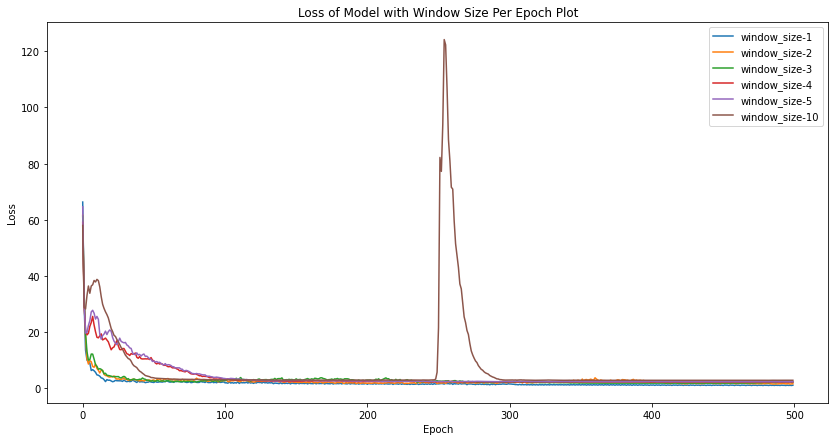

In [61]:

# with open('/content/loss_data/word2vec_ws10', 'wb') as file:
#    pickle.dump(loss_list, file)

##### loading the loss files for different window sizes #####
with open('/content/loss_data/word2vec_ws1', 'rb') as file:
   list_1 = pickle.load(file)
with open('/content/loss_data/word2vec_ws2', 'rb') as file:
   list_2 = pickle.load(file)
with open('/content/loss_data/word2vec_ws3', 'rb') as file:
   list_3 = pickle.load(file)
with open('/content/loss_data/word2vec_ws4', 'rb') as file:
   list_4 = pickle.load(file)
with open('/content/loss_data/word2vec_ws5', 'rb') as file:
   list_5 = pickle.load(file)
with open('/content/loss_data/word2vec_ws10', 'rb') as file:
   list_10 = pickle.load(file)

fig, ax = plt.subplots(figsize=(14, 7))  # creating figure and an axes.
ax.plot(list_1, label='window_size-1')  
ax.plot(list_2, label='window_size-2')
ax.plot(list_3, label='window_size-3')
ax.plot(list_4, label='window_size-4')
ax.plot(list_5, label='window_size-5')
ax.plot(list_10, label='window_size-10')
ax.set_xlabel('Epoch')  # sets an x-label to the axes.
ax.set_ylabel('Loss')  # sets a y-label to the axes.
ax.set_title("Loss of Model with Window Size Per Epoch Plot")  # sets a title to the plot.
ax.legend()  # adds a legend.


# 1.10 Train on the full dataset (0.5 points)

Now, go back to 1.1 and remove the restriction on the number of sentences in your corpus. Then, reexecute code blocks 1.2, 1.3 and 1.6 (or those relevant if you created additional ones). 

* Then, retrain your model on the complete dataset.

* Now, the input weights of the model contain the desired word embeddings! Save them together with the corresponding vocabulary items (Pytorch provides a nice [functionality](https://pytorch.org/tutorials/beginner/saving_loading_models.html) for this).

In [ ]:
word2vec_model.eval()

For **window_size** = 1, **embedding_size** = 300, **Best Epoch loss**: ?????<br/>
For **window_size** = 2, **embedding_size** = 300, **Best Epoch loss**: 1.555 <br/>
For **window_size** = 10, **embedding_size** = 300, **Best Epoch loss**: 1.8762

In [ ]:
## inferencing outputs for the word: bad(खराब) 
predictions = word2vec_model(torch.unsqueeze(torch.tensor(word_to_one_hot('modi')), 0).cuda())



## sampling the top k neighbors for the input word
for i in torch.topk(predictions, 15)[1][0]:
  print(index2word[i.item()])


print('-------')
predictions2 = word2vec_model(torch.unsqueeze(torch.tensor(word_to_one_hot('स्कूल')), 0).cuda())
## sampling the top k neighbors for the input word
for i in torch.topk(predictions2, 15)[1][0]:
  print(index2word[i.item()])


In [ ]:
word2index['modi']

In [ ]:
embedding_weights = word2vec_model.layer1.weight.data


input1 = torch.unsqueeze(torch.tensor(word_to_one_hot('india')), 0).cuda()

print(embedding_weights.shape, input1.T.shape)
embedding1 = torch.matmul(embedding_weights, input1.T)


input2 = torch.unsqueeze(torch.tensor(word_to_one_hot('modi')), 0).cuda()
embedding2 = torch.matmul(embedding_weights, input2.T)


torch.dot(embedding1.squeeze(1), embedding2.squeeze(1))


In [ ]:
from google.colab import files
files.download('loss_data/word2vec_ws10')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>